In [1]:
import pywt
import scipy.stats
import scipy.signal
import scipy.io

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from kpnet.handler import *
from kpnet.network import *
from kpnet.signal import *
from kpnet.callback import *
from kpnet.analysis import *
from kpnet.patterns import *

from wavelets import *

In [5]:
neurons = 64
time_interval = 20000

CPU times: user 3.03 s, sys: 0 ns, total: 3.03 s
Wall time: 3.03 s


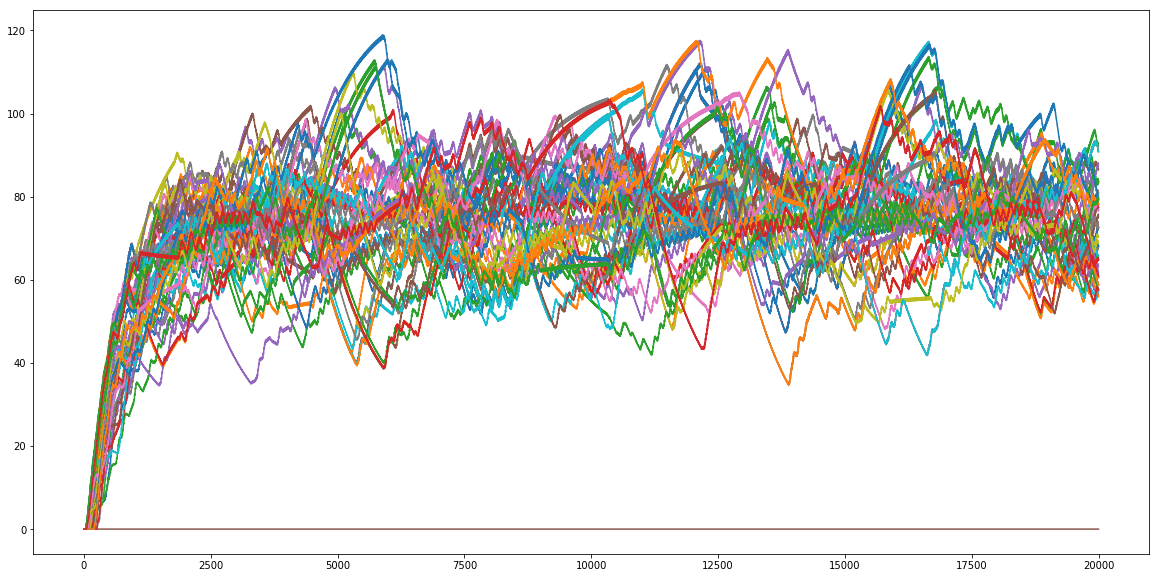

In [16]:
np.random.seed(0)
neuron = 5
net = KPNetworkDelayed(neurons, 3, alpha=0.06, beta=0.2)

callbacks = {}
callbacks['N_' + str(neuron)] = NeuronActivityCallback(time_interval, neuron)

#for i in range(2, 5):
#    callbacks['Trace_' + str(i)] = TraceCallback(time_interval, 189, i)

for i in range(neurons):
    callbacks['W_' + str(i)] = Weight0Callback(time_interval, i, neuron)
    
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(neurons), ZeroSignal(neurons)])
handler = ComputationHandler(time_interval)
%time results = handler.run(net, signal, callbacks)
plt.figure(figsize=(20, 10))
for i in range(neurons):
    plt.plot(results['W_' + str(i)])
plt.show()

CPU times: user 3 s, sys: 0 ns, total: 3 s
Wall time: 2.99 s


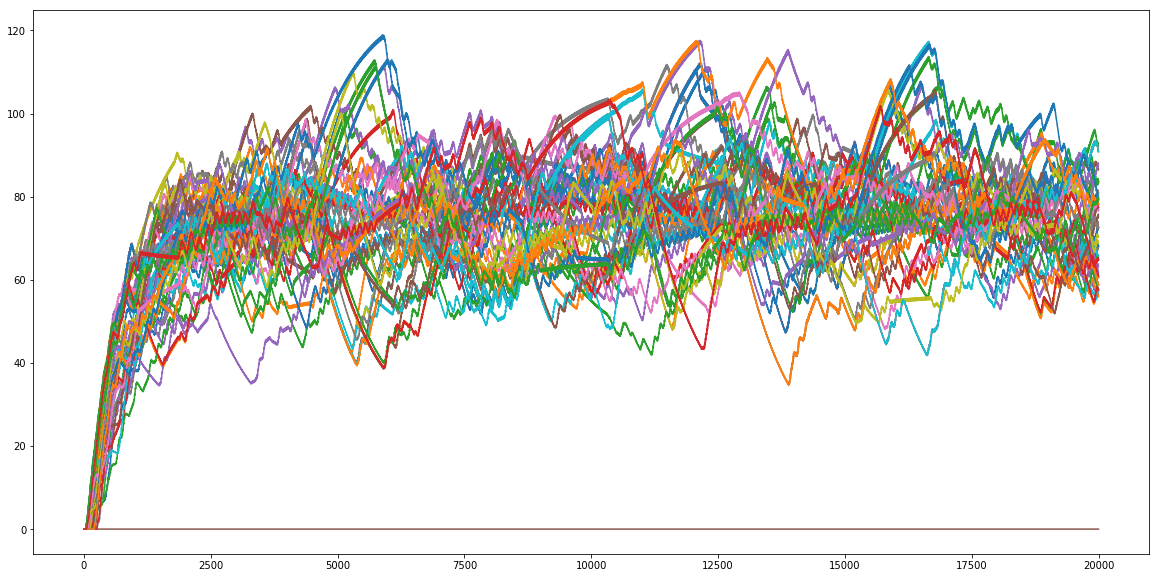

In [18]:
np.random.seed(0)
neuron = 5
net = KPNetworkDelayed(neurons, 3, alpha=0.06, beta=0.2)

callbacks = {}
callbacks['N_' + str(neuron)] = NeuronActivityCallback(time_interval, neuron)

#for i in range(2, 5):
#    callbacks['Trace_' + str(i)] = TraceCallback(time_interval, 189, i)

for i in range(neurons):
    callbacks['W_' + str(i)] = Weight0Callback(time_interval, i, neuron)
    
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(neurons), ZeroSignal(neurons)])
handler = ComputationHandler(time_interval)
%time results = handler.run(net, signal, callbacks)
plt.figure(figsize=(20, 10))
for i in range(neurons):
    plt.plot(results['W_' + str(i)])
plt.show()

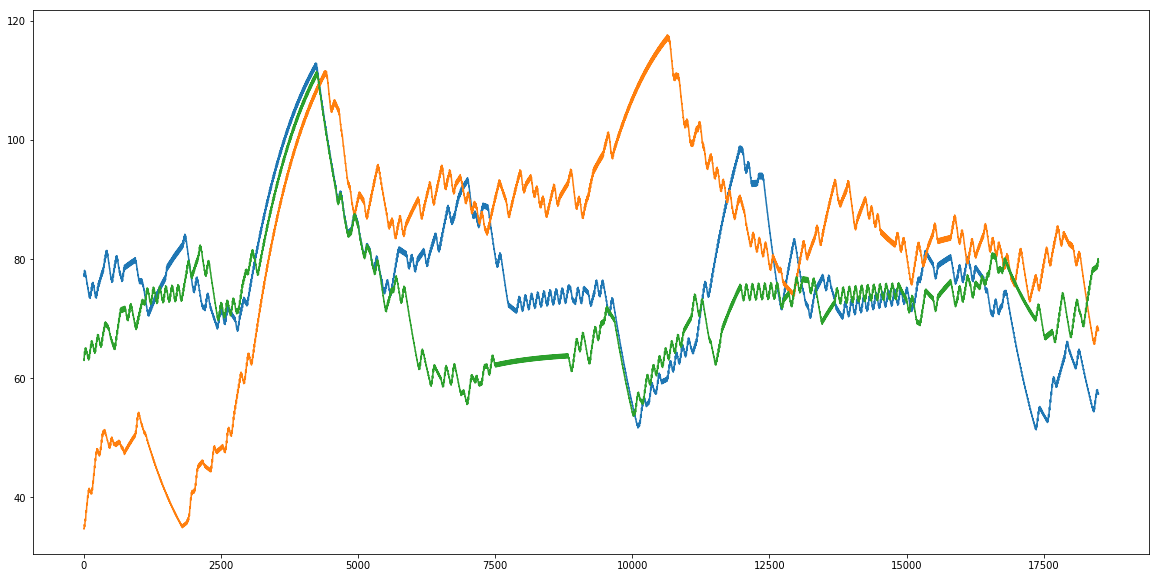

In [52]:
plt.figure(figsize=(20, 10))
plt.plot(results['W_2'][1500:])
plt.plot(results['W_34'][1500:])
plt.plot(results['W_37'][1500:])
plt.show()

CPU times: user 2.97 s, sys: 0 ns, total: 2.97 s
Wall time: 2.97 s


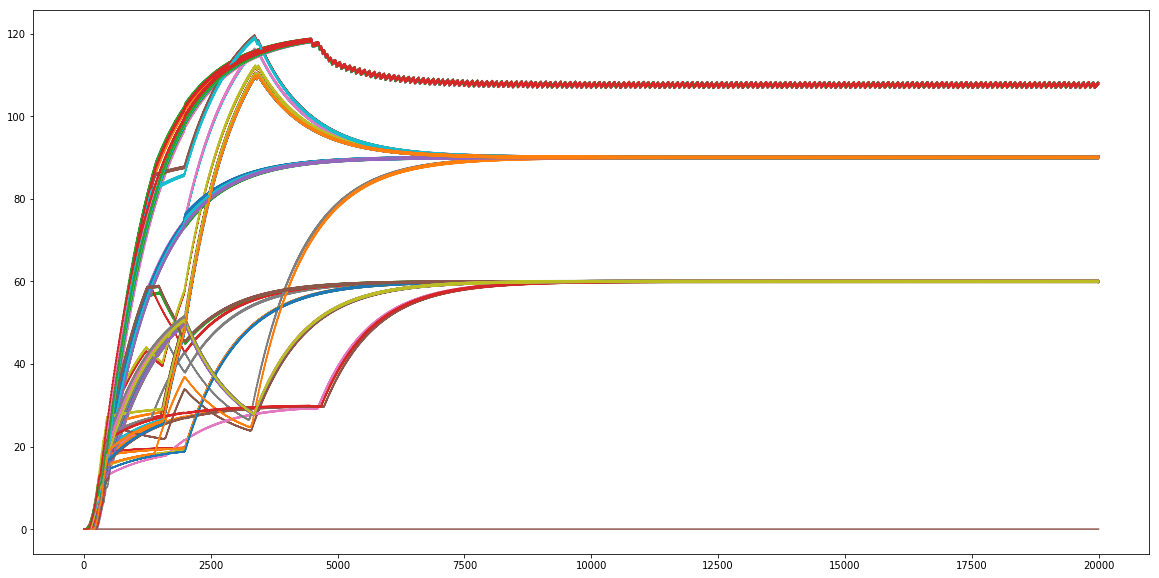

In [17]:
np.random.seed(0)
neuron = 5
net = KPNetworkDelayed(neurons, 3, alpha=0.3, beta=1.2)

callbacks = {}
callbacks['N_' + str(neuron)] = NeuronActivityCallback(time_interval, neuron)

#for i in range(2, 5):
#    callbacks['Trace_' + str(i)] = TraceCallback(time_interval, 189, i)

for i in range(neurons):
    callbacks['W_' + str(i)] = Weight0Callback(time_interval, i, neuron)
    
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(neurons), ZeroSignal(neurons)])
handler = ComputationHandler(time_interval)
%time results = handler.run(net, signal, callbacks)
plt.figure(figsize=(20, 10))
for i in range(neurons):
    plt.plot(results['W_' + str(i)])
plt.show()